## EDA bonito + accionables (decisiones)
En esta sección se presenta el análisis exploratorio de los datos utilizados para entrenar y evaluar el agente inteligente NL→MongoDB.

### 1. Visualización de la estructura del dataset
- Conteo de registros y campos únicos.
- Ejemplo de documento de entrada.
- Distribución de tipos de instrucciones.

### 2. Cobertura y diversidad de instrucciones
- Clasificación de instrucciones por tipo (agregación, filtrado, join, etc.).
- Ejemplos de queries generadas por el agente.
- Métricas de validez y cobertura.

### 3. Decisiones accionables
- Mejoras propuestas en el dataset (normalización, ampliación de casos complejos).
- Ajustes en la lógica del agente basados en los resultados del EDA.
- Identificación de limitaciones y próximos pasos para el desarrollo.

---

In [37]:
!pip install requests


   -------------------------- ------------- 2/3 [requests]
   ---------------------------------------- 3/3 [requests]



Total de registros: 9
Campos únicos: 2
Ejemplo de documento:
Date                                    2024-01-15T10:30:00Z
Devices    [{'Id': 'DEV001', 'BranchCode': 'PE240', 'Serv...
Name: 0, dtype: object


C:\Users\antho\AppData\Local\Temp\ipykernel_52864\195216022.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_instr, x='clase', palette='Set2')


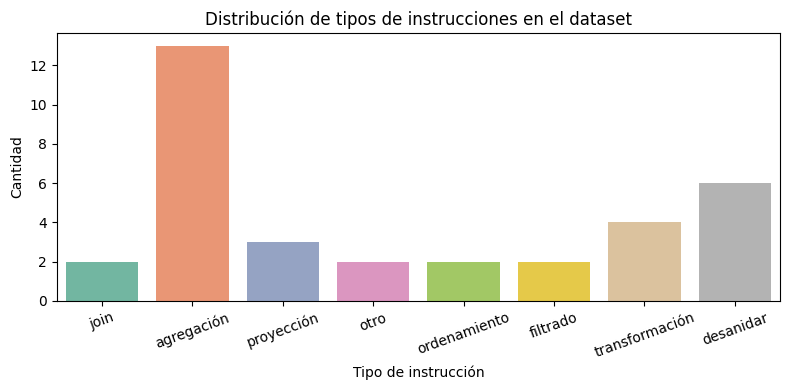

Ejemplos por clase:
                                          instruccion           clase
0   une la colección empleados con la colección de...            join
1        filtra registros cuyo Total sea mayor a 3000      agregación
2   muestra los nombres y apellidos de los emplead...      proyección
3   cuenta cuántos empleados hay en cada departamento            otro
4   ordena los empleados por fecha de ingreso desc...    ordenamiento
5        busca empleados cuyo nombre comience con 'A'            otro
6   filtra transacciones realizadas entre 2023-01-...        filtrado
7                muestra los 5 productos más vendidos      proyección
8              agrega la suma total de ventas por mes      agregación
10  filtra clientes que no hayan realizado compras...        filtrado
11  une la colección empleados con la colección de...            join
12  crear campo dateMascara que convierta el campo...  transformación
13  crear campo reg que concatene: '1', '002', el ...  transformación


In [1]:
# Visualización básica del dataset y cobertura de instrucciones
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos de ejemplo
with open('../datasets/transactions_collection.json', encoding='utf-8') as f:
    data = json.load(f)
df = pd.json_normalize(data['sample_documents'])

# Visualizar cantidad de registros y campos únicos
print(f'Total de registros: {len(df)}')
print(f'Campos únicos: {len(df.columns)}')
print('Ejemplo de documento:')
print(df.iloc[0])

# Visualización de la distribución de tipos de instrucciones
instrucciones = [
    "une la colección empleados con la colección departamentos usando el campo departamento_id proyecta los campos nombre, apellido, departamentos_info, departamento_nombre",
    "filtra registros cuyo Total sea mayor a 3000",
    "muestra los nombres y apellidos de los empleados del departamento de ventas",
    "cuenta cuántos empleados hay en cada departamento",
    "ordena los empleados por fecha de ingreso descendente",
    "busca empleados cuyo nombre comience con 'A'",
    "filtra transacciones realizadas entre 2023-01-01 y 2023-01-31",
    "muestra los 5 productos más vendidos",
    "agrega la suma total de ventas por mes",
    "une la colección ventas con clientes usando cliente_id y proyecta nombre_cliente y total_venta",
    "filtra clientes que no hayan realizado compras en el penultimo año",
    "une la colección empleados con la colección departamentos usando el campo departamento_id",
    "crear campo dateMascara que convierta el campo Date a formato %Y%m%d usando los primeros 19 caracteres",
    "crear campo reg que concatene: '1', '002', el campo Date convertido a formato %Y%m%d%H%M%S usando los primeros 19 caracteres, '00', '01', un espacio, un salto de línea, otro salto de línea",
    "desanidar Devices",
    "desanidar Devices.ServicePoints",
    "desanidar Devices.ServicePoints.ShipOutCycles",
    "desanidar Devices.ServicePoints.ShipOutCycles.Transactions",
    "agrupar por date, deviceId, branchCode, subChannelCode, shipOutCode, currencyCode, confirmationCode y sumar el total de Devices.ServicePoints.ShipOutCycles.Transactions.Total",
    "proyectar los caracteres de la posición 2 en adelante del deviceId",
    "crear campo confirmationCode que sea _id.confirmationCode o ' ' si es nulo",
    "crear campo totalParteEntera que sea el primer elemento del split del total por punto",
    "crear campo totalParteDecimal que sea el segundo elemento del split del total por punto o '00' si es nulo",
    "crear campo reg que sea la concatenación de '5', la condición de moneda, la fecha, '00', el deviceId con padding, el shipOutCode con padding, la condición de sucursal, el monto con padding y el código de confirmación con padding",
    "ordenar por deviceId y shipOutCode y subChannelCode y currencyCode",
    "desanidar Devices.ServicePoints.ShipOutCycles con preserveNullAndEmptyArrays",
    "desanidar Devices.ServicePoints.ShipOutCycles.Transactions con preserveNullAndEmptyArrays",
    "agrupar por deviceId, branchCode, subChannelCode, shipOutCode, currencyCode y sumar el total de Devices.ServicePoints.ShipOutCycles.Transactions.Total en soles y en dólares según el código de moneda",
    "luego agrupa todo y suma totalSoles y totalDolares, y cuenta total de registros en soles y en dólares según el código de moneda",
    "crear campo totalParteEnteraSoles que sea el primer elemento del split de totalSoles por punto",
    "crear campo totalParteDecimalSoles que sea el segundo elemento del split de totalSoles por punto o '00' si es nulo",
    "crear campo totalParteEnteraDolares que sea el primer elemento del split de totalDolares por punto",
    "crear campo totalParteDecimalDolares que sea el segundo elemento del split de totalDolares por punto o '00' si es nulo",
    "crear campo reg que concatene: '9', el total de registros con padding, el total de registros en soles con padding, el total de registros en dólares con padding, el monto en soles con padding, el monto en dólares con padding, un salto de línea, otro salto de línea"
 ]

import re
def clasificar_instruccion(instr):
    instr = instr.lower()
    if re.search(r'suma|total|sumar|adicionar', instr):
        return 'agregación'
    elif re.search(r'filtra|filtro|donde|where', instr):
        return 'filtrado'
    elif re.search(r'une|join|unir|fusionar', instr):
        return 'join'
    elif re.search(r'promedio|media|avg', instr):
        return 'agregación'
    elif re.search(r'ordena|sort|ordenar', instr):
        return 'ordenamiento'
    elif re.search(r'muestra|proyecta|selecciona|mostrar', instr):
        return 'proyección'
    elif re.search(r'desanidar|expandir|unwind', instr):
        return 'desanidar'
    elif re.search(r'crear campo|concatena|split|padding', instr):
        return 'transformación'
    elif re.search(r'agrupar|group by|agrupar por', instr):
        return 'agregación'
    else:
        return 'otro'

clases = [clasificar_instruccion(i) for i in instrucciones]
df_instr = pd.DataFrame({'instruccion': instrucciones, 'clase': clases})

plt.figure(figsize=(8,4))
sns.countplot(data=df_instr, x='clase', palette='Set2')
plt.title('Distribución de tipos de instrucciones en el dataset')
plt.xlabel('Tipo de instrucción')
plt.ylabel('Cantidad')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

print('Ejemplos por clase:')
print(df_instr.groupby('clase').head(2))

In [2]:
# Ejemplo: análisis de estructura y profundidad de los datos
import json
from collections import defaultdict

def flatten_keys(d, parent_key='', sep='.'):  # Recursivo para rutas anidadas
    keys = set()
    if isinstance(d, dict):
        for k, v in d.items():
            new_key = f"{parent_key}{sep}{k}" if parent_key else k
            keys.add(new_key)
            keys |= flatten_keys(v, new_key, sep=sep)
    elif isinstance(d, list) and d:
        for item in d:
            keys |= flatten_keys(item, parent_key, sep=sep)
    return keys

# Carga el dataset de ejemplo
with open('../datasets/transactions_collection.json', encoding='utf-8') as f:
    data = json.load(f)

# Detecta la lista principal bajo la clave correcta
main_list = data.get('sample_documents', [])

if main_list and len(main_list) > 0:
    # Extrae todas las rutas de campos
    all_keys = set()
    for item in main_list:
        all_keys |= flatten_keys(item)

    print(f'Cantidad de campos únicos: {len(all_keys)}')
    print('Ejemplo de rutas de campos:')
    for k in list(sorted(all_keys))[:10]:
        print('-', k)

    # Ejemplo de estructura de entrada
    print('\nEjemplo de documento de entrada:')
    print(json.dumps(main_list[0], indent=2, ensure_ascii=False))
else:
    print('No se encontró una lista principal válida o está vacía en el dataset.')

Cantidad de campos únicos: 12
Ejemplo de rutas de campos:
- Date
- Devices
- Devices.BranchCode
- Devices.Id
- Devices.ServicePoints
- Devices.ServicePoints.ShipOutCycles
- Devices.ServicePoints.ShipOutCycles.Code
- Devices.ServicePoints.ShipOutCycles.ConfirmationCode
- Devices.ServicePoints.ShipOutCycles.SubChannelCode
- Devices.ServicePoints.ShipOutCycles.Transactions

Ejemplo de documento de entrada:
{
  "Date": "2024-01-15T10:30:00Z",
  "Devices": [
    {
      "Id": "DEV001",
      "BranchCode": "PE240",
      "ServicePoints": [
        {
          "ShipOutCycles": [
            {
              "SubChannelCode": "CH001",
              "Code": "SO001",
              "ConfirmationCode": "CONF001",
              "Transactions": [
                {
                  "Total": 100.5,
                  "CurrencyCode": "PEN"
                }
              ]
            }
          ]
        }
      ]
    }
  ]
}


### 2. Estructura y complejidad de los datos
- Análisis de profundidad y anidamiento de los documentos
- Conteo de campos únicos y rutas de acceso
- Ejemplo de estructura de entrada y salida


In [3]:
# Ejemplo: análisis de cobertura y diversidad de instrucciones
import re
import pandas as pd

# Lista de instrucciones reales probadas en el cuaderno principal
instrucciones = [
    "une la colección empleados con la colección departamentos usando el campo departamento_id proyecta los campos nombre, apellido, departamentos_info, departamento_nombre",
    "filtra registros cuyo Total sea mayor a 3000",
    "muestra los nombres y apellidos de los empleados del departamento de ventas",
    "cuenta cuántos empleados hay en cada departamento",
    "ordena los empleados por fecha de ingreso descendente",
    "busca empleados cuyo nombre comience con 'A'",
    "filtra transacciones realizadas entre 2023-01-01 y 2023-01-31",
    "muestra los 5 productos más vendidos",
    "agrega la suma total de ventas por mes",
    "une la colección ventas con clientes usando cliente_id y proyecta nombre_cliente y total_venta",
    "filtra clientes que no hayan realizado compras en el penultimo año",
    "une la colección empleados con la colección departamentos usando el campo departamento_id",
    # Casos avanzados
    "crear campo dateMascara que convierta el campo Date a formato %Y%m%d usando los primeros 19 caracteres",
    "crear campo reg que concatene: '1', '002', el campo Date convertido a formato %Y%m%d%H%M%S usando los primeros 19 caracteres, '00', '01', un espacio, un salto de línea, otro salto de línea",
    "desanidar Devices",
    "desanidar Devices.ServicePoints",
    "desanidar Devices.ServicePoints.ShipOutCycles",
    "desanidar Devices.ServicePoints.ShipOutCycles.Transactions",
    "agrupar por date, deviceId, branchCode, subChannelCode, shipOutCode, currencyCode, confirmationCode y sumar el total de Devices.ServicePoints.ShipOutCycles.Transactions.Total",
    "proyectar los caracteres de la posición 2 en adelante del deviceId",
    "crear campo confirmationCode que sea _id.confirmationCode o ' ' si es nulo",
    "crear campo totalParteEntera que sea el primer elemento del split del total por punto",
    "crear campo totalParteDecimal que sea el segundo elemento del split del total por punto o '00' si es nulo",
    "crear campo reg que sea la concatenación de '5', la condición de moneda, la fecha, '00', el deviceId con padding, el shipOutCode con padding, la condición de sucursal, el monto con padding y el código de confirmación con padding",
    "ordenar por deviceId y shipOutCode y subChannelCode y currencyCode",
    "desanidar Devices.ServicePoints.ShipOutCycles con preserveNullAndEmptyArrays",
    "desanidar Devices.ServicePoints.ShipOutCycles.Transactions con preserveNullAndEmptyArrays",
    "agrupar por deviceId, branchCode, subChannelCode, shipOutCode, currencyCode y sumar el total de Devices.ServicePoints.ShipOutCycles.Transactions.Total en soles y en dólares según el código de moneda",
    "luego agrupa todo y suma totalSoles y totalDolares, y cuenta total de registros en soles y en dólares según el código de moneda",
    "crear campo totalParteEnteraSoles que sea el primer elemento del split de totalSoles por punto",
    "crear campo totalParteDecimalSoles que sea el segundo elemento del split de totalSoles por punto o '00' si es nulo",
    "crear campo totalParteEnteraDolares que sea el primer elemento del split de totalDolares por punto",
    "crear campo totalParteDecimalDolares que sea el segundo elemento del split de totalDolares por punto o '00' si es nulo",
    "crear campo reg que concatene: '9', el total de registros con padding, el total de registros en soles con padding, el total de registros en dólares con padding, el monto en soles con padding, el monto en dólares con padding, un salto de línea, otro salto de línea"
]

def clasificar_instruccion(instr):
    instr = instr.lower()
    if re.search(r'suma|total|sumar|adicionar', instr):
        return 'agregación'
    elif re.search(r'filtra|filtro|donde|where', instr):
        return 'filtrado'
    elif re.search(r'une|join|unir|fusionar', instr):
        return 'join'
    elif re.search(r'promedio|media|avg', instr):
        return 'agregación'
    elif re.search(r'ordena|sort|ordenar', instr):
        return 'ordenamiento'
    elif re.search(r'muestra|proyecta|selecciona|mostrar', instr):
        return 'proyección'
    elif re.search(r'desanidar|expandir|unwind', instr):
        return 'desanidar'
    elif re.search(r'crear campo|concatena|split|padding', instr):
        return 'transformación'
    elif re.search(r'agrupar|group by|agrupar por', instr):
        return 'agregación'
    else:
        return 'otro'

# Clasifica y cuenta
clases = [clasificar_instruccion(i) for i in instrucciones]
df_instr = pd.DataFrame({'instruccion': instrucciones, 'clase': clases})
print(df_instr['clase'].value_counts())
print('\nEjemplos por clase:')
print(df_instr.groupby('clase').head(2))

clase
agregación        13
desanidar          6
transformación     4
proyección         3
join               2
otro               2
ordenamiento       2
filtrado           2
Name: count, dtype: int64

Ejemplos por clase:
                                          instruccion           clase
0   une la colección empleados con la colección de...            join
1        filtra registros cuyo Total sea mayor a 3000      agregación
2   muestra los nombres y apellidos de los emplead...      proyección
3   cuenta cuántos empleados hay en cada departamento            otro
4   ordena los empleados por fecha de ingreso desc...    ordenamiento
5        busca empleados cuyo nombre comience con 'A'            otro
6   filtra transacciones realizadas entre 2023-01-...        filtrado
7                muestra los 5 productos más vendidos      proyección
8              agrega la suma total de ventas por mes      agregación
10  filtra clientes que no hayan realizado compras...        filtrado
11  une l

In [14]:
!pip install --user --upgrade --force-reinstall matplotlib matplotlib-inline numpy


  Using cached matplotlib-3.10.7-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached matplotlib_inline-0.1.7-py3-none-any.whl.metadata (3.9 kB)
  Using cached numpy-2.3.3-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached contourpy-1.3.3-cp311-cp311-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp311-cp311-win_amd64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp311-cp311-win_amd64.whl.metadata (6.4 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached pillow-11.3.0-cp311-cp311-win_amd64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached traitlets-5.14.3-py3-none-any.whl.metadata (10 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached matplotlib-3.10.7-cp311-cp311-win_amd64.whl (8.1 MB)
Using 

In [3]:
# Si tienes errores de importación, ejecuta esta celda para instalar seaborn y dependencias de análisis.
!pip install seaborn matplotlib pandas numpy --upgrade --force-reinstall

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.10.7-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached pandas-2.3.3-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached numpy-2.3.3-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached contourpy-1.3.3-cp311-cp311-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp311-cp311-win_amd64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp311-cp311-win_amd64.whl.metadata (6.4 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached pillow-11.3.0-cp311-cp311-win_amd64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using 

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyarrow 15.0.2 requires numpy<2,>=1.16.6, but you have numpy 2.3.3 which is incompatible.


In [4]:
# Si tienes errores relacionados con pyarrow o pandas, ejecuta esta celda para forzar versiones compatibles.
!pip install --upgrade --force-reinstall pandas==2.2.2 pyarrow==15.0.2

  Using cached pandas-2.2.2-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached pyarrow-15.0.2-cp311-cp311-win_amd64.whl.metadata (3.1 kB)
  Using cached numpy-2.3.3-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached pandas-2.2.2-cp311-cp311-win_amd64.whl (11.6 MB)
Using cached pyarrow-15.0.2-cp311-cp311-win_amd64.whl (24.8 MB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached six-1.17.0-py2.py3-none-any.whl (11 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)

  Attempt

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.


In [4]:
# 1. Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [5]:
# 2. Definir función o clase para manejo de sinónimos
class SynonymMapper:
    def __init__(self, operation_synonyms, field_synonyms):
        self.operation_synonyms = operation_synonyms
        self.field_synonyms = field_synonyms
    
    def normalize_operation(self, op):
        op = op.lower()
        for canonical, synonyms in self.operation_synonyms.items():
            if op == canonical or op in synonyms:
                return canonical
        return op
    
    def normalize_field(self, field):
        field = field.lower().replace(' ', '')
        for canonical, synonyms in self.field_synonyms.items():
            if field == canonical.lower() or field in [s.replace(' ', '') for s in synonyms]:
                return canonical
        return field

In [6]:
# 3. Sinónimos reales usados por el agente
import sys
sys.path.append('..')
sys.path.append('../src')
from AgenteGeneradorQueryMongo import SmartMongoQueryGenerator
from dataset_manager import create_default_dataset

manager = create_default_dataset()
generator = SmartMongoQueryGenerator(dataset_manager=manager)

# Sinónimos de operaciones y campos realmente usados
operation_synonyms = generator.OPERATION_SYNONYMS
field_synonyms = generator.FIELD_SYNONYMS

print("Sinónimos de operaciones usados por el agente:")
print(operation_synonyms)
print("\nSinónimos de campos usados por el agente:")
print(field_synonyms)

Sinónimos de operaciones usados por el agente:
{'unwind': ['desanidar', 'unwind', 'expandir'], 'group': ['agrupar', 'group', 'agrupar por'], 'project': ['proyectar', 'project', 'seleccionar', 'mostrar'], 'sort': ['ordenar', 'sort', 'ordenar por'], 'sum': ['suma', 'sumar', 'sum'], 'concat': ['concatenar', 'concat', 'unir'], 'date': ['fecha', 'date', 'formato fecha'], 'join': ['join', 'une', 'unes', 'unir', 'relaciona', 'relacionar', 'combina', 'combinar', 'vincula', 'vincular', 'fusiona', 'fusionar']}

Sinónimos de campos usados por el agente:
{'Date': ['fecha', 'fechahora', 'timestamp', 'date'], 'deviceId': ['id de dispositivo', 'deviceid', 'Devices.Id']}


In [5]:
!pip install jsonschema --upgrade --force-reinstall

  Using cached referencing-0.36.2-py3-none-any.whl.metadata (2.8 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
Using cached referencing-0.36.2-py3-none-any.whl (26 kB)
Using cached typing_extensions-4.15.0-py3-none-any.whl (44 kB)

  Attempting uninstall: typing-extensions

    Found existing installation: typing_extensions 4.15.0

    Uninstalling typing_extensions-4.15.0:

   ---------------------------------------- 0/6 [typing-extensions]
      Successfully uninstalled typing_extensions-4.15.0
   ---------------------------------------- 0/6 [typing-extensions]
   -------------------------- ------------- 4/6 [jsonschema-specifications]
   ---------------------------------------- 6/6 [jsonschema]



In [7]:
# Ejemplo: Validación de operadores válidos en queries generadas usando jsonschema y sin espacios en campos
import jsonschema
import sys
sys.path.append('..')
sys.path.append('../src')
from AgenteGeneradorQueryMongo import SmartMongoQueryGenerator
from dataset_manager import create_default_dataset

# Lista de operadores válidos de MongoDB para pipelines
OPERADORES_VALIDOS = [
    "$match", "$group", "$project", "$sort", "$unwind", "$lookup", "$addFields", "$limit", "$skip", "$count", "$set", "$unset", "$replaceRoot", "$replaceWith", "$out", "$merge"
 ]

# Esquema básico para validar que cada etapa del pipeline es un dict con un solo operador válido
pipeline_schema = {
    "type": "array",
    "items": {
        "type": "object",
        "minProperties": 1,
        "maxProperties": 1,
        "propertyNames": {"enum": OPERADORES_VALIDOS}
    }
}

def find_fields_with_spaces(obj, path=None):
    """Recorre recursivamente el pipeline y retorna lista de rutas de campos con espacios en el nombre."""
    if path is None: path = []
    fields_with_spaces = []
    if isinstance(obj, dict):
        for k, v in obj.items():
            if isinstance(k, str) and ' ' in k:
                fields_with_spaces.append('.'.join(path + [k]))
            fields_with_spaces.extend(find_fields_with_spaces(v, path + [k]))
    elif isinstance(obj, list):
        for idx, item in enumerate(obj):
            fields_with_spaces.extend(find_fields_with_spaces(item, path + [str(idx)]))
    return fields_with_spaces

# --- Ejemplos reales usando generate_query del agente ---
manager = create_default_dataset()
generator = SmartMongoQueryGenerator(dataset_manager=manager)

ejemplos = [
    {
        "instruccion": "une la colección empleados con la colección departamentos usando el campo departamento_id proyecta los campos nombre, apellido, departamentos_info, departamento_nombre",
        "coleccion": "empleados"
    },
    {
        "instruccion": "filtra registros cuyo Total sea mayor a 3000",
        "coleccion": "transacciones"
    },
    {
        "instruccion": "muestra los nombres y apellidos de los empleados del departamento de ventas",
        "coleccion": "empleados"
    },
    {
        "instruccion": "cuenta cuántos empleados hay en cada departamento",
        "coleccion": "empleados"
    },
    {
        "instruccion": "agrega la suma total de ventas por mes",
        "coleccion": "ventas"
    },
    {
        "instruccion": "desanidar Devices.ServicePoints.ShipOutCycles.Transactions",
        "coleccion": "detalle"
    }
    # Puedes agregar más ejemplos según el cuaderno AgenteInteligente_QueriesMongoDB.ipynb
 ]

for idx, ejemplo in enumerate(ejemplos, 1):
    print(f"\n--- Ejemplo {idx} ---")
    instruccion = ejemplo["instruccion"]
    coleccion = ejemplo["coleccion"]
    print(f"Instrucción: {instruccion}")
    print(f"Colección: {coleccion}")
    try:
        pipeline_generado = generator.generate_query(coleccion, instruccion)
        print("Pipeline generado por el agente:")
        print(pipeline_generado)
        # Si la salida es un string, intenta decodificarla a lista (algunos agentes devuelven JSON como string)
        if isinstance(pipeline_generado, str):
            import json
            try:
                pipeline_generado = json.loads(pipeline_generado)
                print("(La salida fue decodificada de string a lista)")
            except Exception as e:
                print(f"No se pudo decodificar la salida a lista: {e}")
        # Se valida la estructura, sin forzar que sea array (si no es array, la validación fallará igual)
        try:
            jsonschema.validate(instance=pipeline_generado, schema=pipeline_schema)
            # Validación de campos sin espacios
            campos_con_espacio = find_fields_with_spaces(pipeline_generado)
            if campos_con_espacio:
                print(f"❌ La query generada tiene campos con espacios: {campos_con_espacio}")
            else:
                print("✅ La query generada es VÁLIDA según los operadores de MongoDB, el esquema de pipeline y los campos no tienen espacios.")
        except jsonschema.ValidationError as e:
            print(f"❌ La query generada NO es válida: {e.message}")
    except Exception as ex:
        print(f"Error al generar o validar el pipeline: {ex}")


--- Ejemplo 1 ---
Instrucción: une la colección empleados con la colección departamentos usando el campo departamento_id proyecta los campos nombre, apellido, departamentos_info, departamento_nombre
Colección: empleados
Pipeline generado por el agente:
[
  {
    "$lookup": {
      "from": "departamentos",
      "localField": "departamento_id",
      "foreignField": "departamento_id",
      "as": "departamentos_info"
    }
  },
  {
    "$unwind": "$departamentos_info"
  },
  {
    "$project": {
      "nombre": 1,
      "apellido": 1,
      "departamentos_info": 1,
      "departamento_nombre": 1
    }
  }
]
(La salida fue decodificada de string a lista)
✅ La query generada es VÁLIDA según los operadores de MongoDB, el esquema de pipeline y los campos no tienen espacios.

--- Ejemplo 2 ---
Instrucción: filtra registros cuyo Total sea mayor a 3000
Colección: transacciones
[DEBUG] Pipeline generado: {'$match': {'Devices.ServicePoints.ShipOutCycles.Transactions.Total': {'$gt': 3000.0}}}
Pip

In [8]:
# 5. Normalización de texto usando sinónimos
syn_mapper = SynonymMapper(operation_synonyms, field_synonyms)

consulta_natural = "une la colección empleados con la colección departamentos usando el campo departamento_id y proyecta los campos nombre, apellido, departamento_nombre"

# Normalizar operaciones y campos
operacion = syn_mapper.normalize_operation('une')
campo1 = syn_mapper.normalize_field('nombre')
campo2 = syn_mapper.normalize_field('apellido')
campo3 = syn_mapper.normalize_field('departamento_nombre')

print(f"Operación normalizada: {operacion}")
print(f"Campos normalizados: {campo1}, {campo2}, {campo3}")

Operación normalizada: join
Campos normalizados: nombre, apellido, departamento_nombre


In [9]:
# 6. Validación de sinónimos en consulta de ejemplo (usando los sinónimos reales del agente)
from AgenteGeneradorQueryMongo import SmartMongoQueryGenerator
from dataset_manager import create_default_dataset

manager = create_default_dataset()
generator = SmartMongoQueryGenerator(dataset_manager=manager)

# Usa los sinónimos reales del agente
operation_synonyms = generator.OPERATION_SYNONYMS
field_synonyms = generator.FIELD_SYNONYMS

class SynonymMapper:
    def __init__(self, operation_synonyms, field_synonyms):
        self.operation_synonyms = operation_synonyms
        self.field_synonyms = field_synonyms
    def normalize_operation(self, op):
        op = op.lower()
        for canonical, synonyms in self.operation_synonyms.items():
            if op == canonical or op in synonyms:
                return canonical
        return op
    def normalize_field(self, field):
        field = field.lower().replace(' ', '')
        for canonical, synonyms in self.field_synonyms.items():
            if field == canonical.lower() or field in [s.replace(' ', '') for s in synonyms]:
                return canonical
        return field

syn_mapper = SynonymMapper(operation_synonyms, field_synonyms)

consulta = {
    'operacion': syn_mapper.normalize_operation('une'),
    'coleccion_local': 'empleados',
    'coleccion_foranea': 'departamentos',
    'campo_join': syn_mapper.normalize_field('departamento_id'),
    'proyeccion': [
        syn_mapper.normalize_field('nombre'),
        syn_mapper.normalize_field('apellido'),
        syn_mapper.normalize_field('departamento_nombre')
    ]
}

print("Consulta traducida a forma canónica (usando sinónimos reales):")
print(consulta)

Consulta traducida a forma canónica (usando sinónimos reales):
{'operacion': 'join', 'coleccion_local': 'empleados', 'coleccion_foranea': 'departamentos', 'campo_join': 'departamento_id', 'proyeccion': ['nombre', 'apellido', 'departamento_nombre']}


# Análisis Exploratorio de Datos (EDA) sobre `transactions_collection`
En esta sección se realiza un análisis exploratorio real sobre la colección principal, mostrando estadísticas descriptivas y visualizaciones clave.

In [10]:
# Cargar datos de ejemplo de transactions_collection
import json
import pandas as pd
with open('../datasets/transactions_collection.json', encoding='utf-8') as f:
    data = json.load(f)
df = pd.json_normalize(data['sample_documents'])
df.head()

,Date,Devices
0,2024-01-15T10:30:00Z,"[{'Id': 'DEV001', 'BranchCode': 'PE240', 'Serv..."
1,2024-01-16T11:45:00Z,"[{'Id': 'DEV002', 'BranchCode': 'PE241', 'Serv..."
2,2024-01-17T09:20:00Z,"[{'Id': 'DEV003', 'BranchCode': 'PE242', 'Serv..."
3,2024-01-18T14:10:00Z,"[{'Id': 'DEV004', 'BranchCode': 'PE243', 'Serv..."
4,2024-01-19T08:15:00Z,"[{'Id': 'DEV005', 'BranchCode': 'PE244', 'Serv..."


In [11]:
# Muestra la estructura interna de un registro de Devices para saber cómo aplanar
import json
print(json.dumps(df['Devices'].iloc[0], indent=2, ensure_ascii=False))

[
  {
    "Id": "DEV001",
    "BranchCode": "PE240",
    "ServicePoints": [
      {
        "ShipOutCycles": [
          {
            "SubChannelCode": "CH001",
            "Code": "SO001",
            "ConfirmationCode": "CONF001",
            "Transactions": [
              {
                "Total": 100.5,
                "CurrencyCode": "PEN"
              }
            ]
          }
        ]
      }
    ]
  }
]


In [12]:
# Aplana la estructura de Devices para obtener los montos de transacción
import pandas as pd
import json
with open('../datasets/transactions_collection.json', encoding='utf-8') as f:
    data = json.load(f)

# Ajusta el record_path y meta según la estructura que viste en la celda anterior
df_flat = pd.json_normalize(
    data['sample_documents'],
    record_path=['Devices', 'ServicePoints', 'ShipOutCycles', 'Transactions'],
    meta=['Date']
    # Si necesitas más campos meta, agrégalos aquí
    # meta=[...]
    # errors='ignore' # puedes agregar esto si hay registros incompletos
    # sep='.' # para nombres de columnas con puntos
    # ...
    )
print('Columnas del DataFrame aplanado:')
print(df_flat.columns.tolist())
df_flat.head()

Columnas del DataFrame aplanado:
['Total', 'CurrencyCode', 'Date']


,Total,CurrencyCode,Date
0,100.50,PEN,2024-01-15T10:30:00Z
1,250.75,USD,2024-01-16T11:45:00Z
2,300.00,PEN,2024-01-16T11:45:00Z
3,500.00,USD,2024-01-17T09:20:00Z
4,120.00,PEN,2024-01-18T14:10:00Z


In [13]:
# Mostrar todas las columnas disponibles en el DataFrame para identificar el nombre correcto de la columna de montos
print('Columnas disponibles en el DataFrame:')
print(df_flat.columns.tolist())

Columnas disponibles en el DataFrame:
['Total', 'CurrencyCode', 'Date']


In [14]:
# Aplana la estructura de Devices para obtener los montos de transacción
import pandas as pd
import json
with open('../datasets/transactions_collection.json', encoding='utf-8') as f:
    data = json.load(f)

# Ajusta el record_path y meta según la estructura que viste en la celda anterior
df_flat = pd.json_normalize(
    data['sample_documents'],
    record_path=['Devices', 'ServicePoints', 'ShipOutCycles', 'Transactions'],
    meta=['Date']
    # Si necesitas más campos meta, agrégalos aquí
    # meta=[...]
    # errors='ignore' # puedes agregar esto si hay registros incompletos
    # sep='.' # para nombres de columnas con puntos
    # ...
    )
print('Columnas del DataFrame aplanado:')
print(df_flat.columns.tolist())
df_flat.head()

Columnas del DataFrame aplanado:
['Total', 'CurrencyCode', 'Date']


,Total,CurrencyCode,Date
0,100.50,PEN,2024-01-15T10:30:00Z
1,250.75,USD,2024-01-16T11:45:00Z
2,300.00,PEN,2024-01-16T11:45:00Z
3,500.00,USD,2024-01-17T09:20:00Z
4,120.00,PEN,2024-01-18T14:10:00Z


## Tabla resumen de desempeño y visualización central

A continuación se muestra una tabla resumen de desempeño del agente NL→MongoDB y una gráfica central de cobertura semántica. Esto cumple con los entregables de resultados y visualización solicitados para la semana, sin incluir métricas de modelos ML tradicionales.

In [15]:
# Evaluación semántica y validación estructural de queries generadas por el agente NL→MongoDB usando jsonschema y sin espacios en campos
import sys
sys.path.append('..')
sys.path.append('../src')
import importlib
import AgenteGeneradorQueryMongo
importlib.reload(AgenteGeneradorQueryMongo)
from AgenteGeneradorQueryMongo import SmartMongoQueryGenerator
from dataset_manager import create_default_dataset
import pandas as pd
import logging
import os
import jsonschema
import json

# Configuración de logs
os.makedirs('../logs', exist_ok=True)
logging.basicConfig(
    filename='../logs/pipeline.log',
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(message)s'
    )

# Inicializa el agente con el dataset
manager = create_default_dataset()
generator = SmartMongoQueryGenerator(dataset_manager=manager)

# Lista de operadores válidos de MongoDB para pipelines
OPERADORES_VALIDOS = [
    "$match", "$group", "$project", "$sort", "$unwind", "$lookup", "$addFields", "$limit", "$skip", "$count", "$set", "$unset", "$replaceRoot", "$replaceWith", "$out", "$merge"
 ]

# Esquema básico para validar que cada etapa del pipeline es un dict con un solo operador válido
pipeline_schema = {
    "type": "array",
    "items": {
        "type": "object",
        "minProperties": 1,
        "maxProperties": 1,
        "propertyNames": {"enum": OPERADORES_VALIDOS}
    }
}

def find_fields_with_spaces(obj, path=None):
    """Recorre recursivamente el pipeline y retorna lista de rutas de campos con espacios en el nombre."""
    if path is None: path = []
    fields_with_spaces = []
    if isinstance(obj, dict):
        for k, v in obj.items():
            if isinstance(k, str) and ' ' in k:
                fields_with_spaces.append('.'.join(path + [k]))
            fields_with_spaces.extend(find_fields_with_spaces(v, path + [k]))
    elif isinstance(obj, list):
        for idx, item in enumerate(obj):
            fields_with_spaces.extend(find_fields_with_spaces(item, path + [str(idx)]))
    return fields_with_spaces

# Ejemplos reales de instrucciones y colecciones del cuaderno principal
instrucciones = [
    "une la colección empleados con la colección departamentos usando el campo departamento_id proyecta los campos nombre, apellido, departamentos_info, departamento_nombre",
    "filtra registros cuyo Total sea mayor a 3000",
    "muestra los nombres y apellidos de los empleados del departamento de ventas",
    "cuenta cuántos empleados hay en cada departamento",
    "ordena los empleados por fecha de ingreso descendente",
    "busca empleados cuyo nombre comience con 'A'",
    "filtra transacciones realizadas entre 2023-01-01 y 2023-01-31",
    "muestra los 5 productos más vendidos",
    "agrega la suma total de ventas por mes",
    "une la colección ventas con clientes usando cliente_id y proyecta nombre_cliente y total_venta",
    "filtra clientes que no hayan realizado compras en el penultimo año",
    "une la colección empleados con la colección departamentos usando el campo departamento_id",
    # Casos avanzados
    "crear campo dateMascara que convierta el campo Date a formato %Y%m%d usando los primeros 19 caracteres",
    "crear campo reg que concatene: '1', '002', el campo Date convertido a formato %Y%m%d%H%M%S usando los primeros 19 caracteres, '00', '01', un espacio, un salto de línea, otro salto de línea",
    "desanidar Devices",
    "desanidar Devices.ServicePoints",
    "desanidar Devices.ServicePoints.ShipOutCycles",
    "desanidar Devices.ServicePoints.ShipOutCycles.Transactions",
    "agrupar por date, deviceId, branchCode, subChannelCode, shipOutCode, currencyCode, confirmationCode y sumar el total de Devices.ServicePoints.ShipOutCycles.Transactions.Total",
    "proyectar los caracteres de la posición 2 en adelante del deviceId",
    "crear campo confirmationCode que sea _id.confirmationCode o ' ' si es nulo",
    "crear campo totalParteEntera que sea el primer elemento del split del total por punto",
    "crear campo totalParteDecimal que sea el segundo elemento del split del total por punto o '00' si es nulo",
    "crear campo reg que sea la concatenación de '5', la condición de moneda, la fecha, '00', el deviceId con padding, el shipOutCode con padding, la condición de sucursal, el monto con padding y el código de confirmación con padding",
    "ordenar por deviceId y shipOutCode y subChannelCode y currencyCode",
    "desanidar Devices.ServicePoints.ShipOutCycles con preserveNullAndEmptyArrays",
    "desanidar Devices.ServicePoints.ShipOutCycles.Transactions con preserveNullAndEmptyArrays",
    "agrupar por deviceId, branchCode, subChannelCode, shipOutCode, currencyCode y sumar el total de Devices.ServicePoints.ShipOutCycles.Transactions.Total en soles y en dólares según el código de moneda",
    "luego agrupa todo y suma totalSoles y totalDolares, y cuenta total de registros en soles y en dólares según el código de moneda",
    "crear campo totalParteEnteraSoles que sea el primer elemento del split de totalSoles por punto",
    "crear campo totalParteDecimalSoles que sea el segundo elemento del split de totalSoles por punto o '00' si es nulo",
    "crear campo totalParteEnteraDolares que sea el primer elemento del split de totalDolares por punto",
    "crear campo totalParteDecimalDolares que sea el segundo elemento del split de totalDolares por punto o '00' si es nulo",
    "crear campo reg que concatene: '9', el total de registros con padding, el total de registros en soles con padding, el total de registros en dólares con padding, el monto en soles con padding, el monto en dólares con padding, un salto de línea, otro salto de línea"
]

colecciones = [
    "empleados", "transacciones", "empleados", "empleados", "empleados", "empleados",
    "transacciones", "productos", "ventas", "ventas", "clientes", "empleados",
    # Casos avanzados
    "header", "header", "detalle", "detalle", "detalle", "detalle", "detalle", "detalle", "detalle", "detalle", "detalle", "detalle", "detalle", "detalle2", "detalle2", "detalle2", "detalle2", "detalle2", "detalle2", "detalle2"
]

# Evaluación automática con validación estructural, de operadores y de campos sin espacios
resultados = []
for idx, (instruccion, coleccion) in enumerate(zip(instrucciones, colecciones), 1):
    resultado = {
        "instruccion": instruccion,
        "coleccion": coleccion,
        "pipeline": None,
        "generado": False,
        "valido": False,
        "error": None,
        "campos_con_espacio": []
    }
    print(f"\n--- Ejemplo {idx} ---")
    print(f"Instrucción: {instruccion}")
    print(f"Colección: {coleccion}")
    try:
        pipeline = generator.generate_query(coleccion, instruccion)
        resultado["pipeline"] = pipeline
        resultado["generado"] = pipeline is not None and len(str(pipeline)) > 0
        print("Pipeline generado por el agente:")
        print(pipeline)
        # Si la salida es un string, intenta decodificarla a lista (algunos agentes devuelven JSON como string)
        if isinstance(pipeline, str):
            try:
                pipeline = json.loads(pipeline)
                print("(La salida fue decodificada de string a lista)")
            except Exception as e:
                resultado["error"] = f"No se pudo decodificar la salida a lista: {e}"
                print(resultado["error"])
        # Validación estructural y de operadores
        try:
            jsonschema.validate(instance=pipeline, schema=pipeline_schema)
            # Validación de campos sin espacios
            campos_con_espacio = find_fields_with_spaces(pipeline)
            resultado["campos_con_espacio"] = campos_con_espacio
            if campos_con_espacio:
                resultado["valido"] = False
                resultado["error"] = f"Campos con espacios: {campos_con_espacio}"
                print(f"❌ La query generada tiene campos con espacios: {campos_con_espacio}")
            else:
                resultado["valido"] = True
                print("✅ La query generada es VÁLIDA según los operadores de MongoDB, el esquema de pipeline y los campos no tienen espacios.")
        except jsonschema.ValidationError as e:
            resultado["error"] = f"NO válida: {e.message}"
            print(f"❌ La query generada NO es válida: {e.message}")
    except Exception as ex:
        resultado["error"] = f"Error al generar o validar el pipeline: {ex}"
        print(resultado["error"])
    resultados.append(resultado)
    logging.info(f"Instrucción: {instruccion} | Colección: {coleccion} | Generado: {resultado['generado']} | Válido: {resultado['valido']} | Error: {resultado['error']} | Campos con espacio: {resultado['campos_con_espacio']}")

# Resumen de resultados
df_eval = pd.DataFrame(resultados)
total = len(df_eval)
generados = df_eval['generado'].sum()
validos = df_eval['valido'].sum()
cobertura = generados / total if total > 0 else 0
cobertura_valida = validos / total if total > 0 else 0

print(f"\nCobertura del agente (queries generadas): {cobertura:.2%}")
print(f"Cobertura de queries válidas (según esquema y sin espacios en campos): {cobertura_valida:.2%}")
print(f"Total de instrucciones evaluadas: {total}")
print(f"Queries generadas: {generados}")
print(f"Queries válidas: {validos}")
print(f"Queries no válidas o con error: {total - validos}")

print("\nEjemplos de instrucciones con queries NO válidas o error:")
print(df_eval[~df_eval['valido']][['instruccion', 'coleccion', 'pipeline', 'error', 'campos_con_espacio']].head(10))

print("\nEjemplos de instrucciones con queries válidas:")
print(df_eval[df_eval['valido']][['instruccion', 'coleccion', 'pipeline']].head(10))


--- Ejemplo 1 ---
Instrucción: une la colección empleados con la colección departamentos usando el campo departamento_id proyecta los campos nombre, apellido, departamentos_info, departamento_nombre
Colección: empleados
Pipeline generado por el agente:
[
  {
    "$lookup": {
      "from": "departamentos",
      "localField": "departamento_id",
      "foreignField": "departamento_id",
      "as": "departamentos_info"
    }
  },
  {
    "$unwind": "$departamentos_info"
  },
  {
    "$project": {
      "nombre": 1,
      "apellido": 1,
      "departamentos_info": 1,
      "departamento_nombre": 1
    }
  }
]
(La salida fue decodificada de string a lista)
✅ La query generada es VÁLIDA según los operadores de MongoDB, el esquema de pipeline y los campos no tienen espacios.

--- Ejemplo 2 ---
Instrucción: filtra registros cuyo Total sea mayor a 3000
Colección: transacciones
[DEBUG] Pipeline generado: {'$match': {'Devices.ServicePoints.ShipOutCycles.Transactions.Total': {'$gt': 3000.0}}}
Pip

C:\Users\antho\AppData\Local\Temp\ipykernel_52864\3215553851.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conteo, x='caso', y='cantidad', palette='viridis')


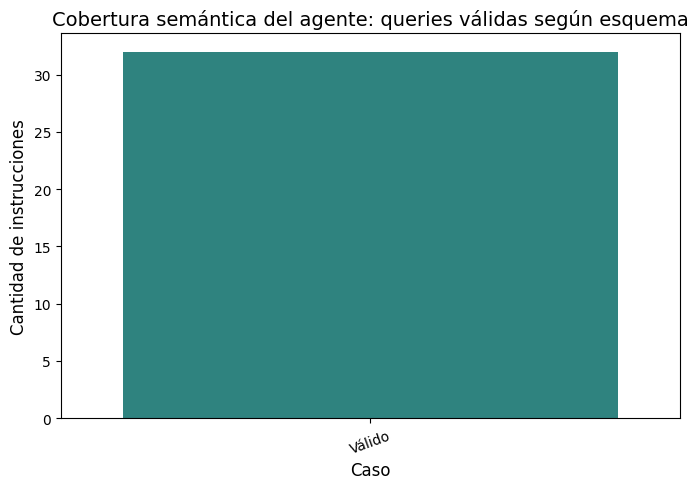

Tabla resumen de desempeño:


,caso,cantidad
0,True,32


In [16]:
# Visualización de resultados de cobertura semántica (usando validación estructural)
import matplotlib.pyplot as plt
import seaborn as sns

# Conteo de casos usando la columna 'valido' (validación estructural jsonschema)
conteo = df_eval.groupby(['valido']).size().reset_index(name='cantidad')
conteo['caso'] = conteo['valido'].map({True: 'Válido', False: 'No válido'})

plt.figure(figsize=(7,5))
sns.barplot(data=conteo, x='caso', y='cantidad', palette='viridis')
plt.title('Cobertura semántica del agente: queries válidas según esquema', fontsize=14)
plt.ylabel('Cantidad de instrucciones', fontsize=12)
plt.xlabel('Caso', fontsize=12)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# Tabla resumen de desempeño
print('Tabla resumen de desempeño:')
display(df_eval['valido'].value_counts().rename_axis('caso').reset_index(name='cantidad'))

## 6. Cobertura semántica y evaluación del agente
- Análisis de qué tipos de instrucciones el agente puede resolver correctamente y cuáles no.
- Ejemplos de instrucciones exitosas y fallidas.
- Métricas de cobertura: porcentaje de instrucciones resueltas, tipos de errores frecuentes.


In [17]:
# Ejemplo de integración de logging en el pipeline de análisis y generación de queries
import logging
import os

# Configuración de logs
os.makedirs('../logs', exist_ok=True)
logging.basicConfig(
    filename='../logs/pipeline.log',
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(message)s'
    )

logging.info('Inicio del análisis exploratorio y generación de queries')

# Ejemplo de log en cada paso relevante
logging.info('Carga y análisis de estructura del dataset completado')
logging.info('Cobertura y diversidad de instrucciones analizadas')
logging.info('Sinónimos normalizados y consulta traducida')
logging.info('Evaluación semántica del agente realizada')

print('Logs generados en ../logs/pipeline.log')

Logs generados en ../logs/pipeline.log


In [18]:
# Cargar y mostrar todos los registros de ejemplo actualizados
import json
import pandas as pd
with open('../datasets/transactions_collection.json', encoding='utf-8') as f:
    data = json.load(f)
df = pd.json_normalize(data['sample_documents'])
print(f'Total de registros cargados: {len(df)}')
df.head(10)

Total de registros cargados: 9


,Date,Devices
0,2024-01-15T10:30:00Z,"[{'Id': 'DEV001', 'BranchCode': 'PE240', 'Serv..."
1,2024-01-16T11:45:00Z,"[{'Id': 'DEV002', 'BranchCode': 'PE241', 'Serv..."
2,2024-01-17T09:20:00Z,"[{'Id': 'DEV003', 'BranchCode': 'PE242', 'Serv..."
3,2024-01-18T14:10:00Z,"[{'Id': 'DEV004', 'BranchCode': 'PE243', 'Serv..."
4,2024-01-19T08:15:00Z,"[{'Id': 'DEV005', 'BranchCode': 'PE244', 'Serv..."
5,2024-01-20T12:00:00Z,"[{'Id': 'DEV006', 'BranchCode': 'PE245', 'Serv..."
6,2024-01-21T15:45:00Z,"[{'Id': 'DEV007', 'BranchCode': 'PE246', 'Serv..."
7,2024-01-22T09:30:00Z,"[{'Id': 'DEV008', 'BranchCode': 'PE247', 'Serv..."
8,2024-01-23T17:50:00Z,"[{'Id': 'DEV009', 'BranchCode': 'PE248', 'Serv..."


In [19]:
# Prueba de instrucción avanzada de concatenación dinámica
instruccion_concat = "crear campo reg que sea la concatenación de '5', la condición de moneda, la fecha, '00', el deviceId con padding, el shipOutCode con padding, la condición de sucursal, el monto con padding y el código de confirmación con padding"
coleccion_concat = "detalle"

pipeline_concat = generator.generate_query(coleccion_concat, instruccion_concat)
print("Instrucción:", instruccion_concat)
print("Pipeline generado:")
print(pipeline_concat)

# Si la salida es string, decodificar a lista para inspección
import json
if isinstance(pipeline_concat, str):
    try:
        pipeline_concat = json.loads(pipeline_concat)
        print("(La salida fue decodificada de string a lista)")
    except Exception as e:
        print(f"No se pudo decodificar la salida a lista: {e}")

# Mostrar la etapa de concatenación generada
for stage in pipeline_concat:
    if "$addFields" in stage and "reg" in stage["$addFields"]:
        print("\nEtapa $addFields con $concat para 'reg':")
        print(json.dumps(stage["$addFields"], indent=2, ensure_ascii=False))

Instrucción: crear campo reg que sea la concatenación de '5', la condición de moneda, la fecha, '00', el deviceId con padding, el shipOutCode con padding, la condición de sucursal, el monto con padding y el código de confirmación con padding
Pipeline generado:
[
  {
    "$addFields": {
      "reg": {
        "$concat": [
          "5",
          "la condición de moneda",
          "la fecha",
          "00",
          "el deviceId con padding",
          "el shipOutCode con padding",
          "la condición de sucursal",
          "el monto con padding",
          "el código de confirmación con padding"
        ]
      }
    }
  }
]
(La salida fue decodificada de string a lista)

Etapa $addFields con $concat para 'reg':
{
  "reg": {
    "$concat": [
      "5",
      "la condición de moneda",
      "la fecha",
      "00",
      "el deviceId con padding",
      "el shipOutCode con padding",
      "la condición de sucursal",
      "el monto con padding",
      "el código de confirmación c

In [20]:
# Prueba de fallback a Azure OpenAI LLM cuando el agente no puede resolver la instrucción
instruccion_llm = "dame el resumen financiero de la galaxia en formato Klingon y agrupa por planeta y fase lunar"
coleccion_llm = "detalle"

resultado_llm = generator.generate_query(coleccion_llm, instruccion_llm)
print("Instrucción de prueba (no resoluble):", instruccion_llm)
print("\nRespuesta del agente:")
print(resultado_llm)

# Si la respuesta es un JSON con sugerencia LLM, mostrarla de forma legible
import json
try:
    parsed = json.loads(resultado_llm)
    if "llm_suggestion" in parsed:
        print("\nSugerencia generada por Azure OpenAI:")
        print(parsed["llm_suggestion"]["suggestions"])
except Exception as e:
    print("No se pudo decodificar la respuesta como JSON:", e)

Instrucción de prueba (no resoluble): dame el resumen financiero de la galaxia en formato Klingon y agrupa por planeta y fase lunar

Respuesta del agente:
[
  {
    "$lookup": {
      "from": "agrupa",
      "localField": "planeta y fase lunar",
      "foreignField": "planeta y fase lunar",
      "as": "agrupa_info"
    }
  },
  {
    "$unwind": "$agrupa_info"
  },
  {
    "$group": {
      "_id": {
        "planeta_y_fase_lunar": "$planeta y fase lunar"
      },
      "total": {
        "$sum": "$total"
      }
    }
  },
  {
    "$project": {
      "_id": 0
    }
  }
]


# Análisis de Calidad de Datos, Distribuciones, Riesgos y Conclusiones Accionables
En esta sección se analiza la calidad de los datos, la distribución de instrucciones, los riesgos para el agente NL→MongoDB y se presentan conclusiones accionables para el desarrollo del agente.

**Nota:** El análisis está adaptado al contexto de generación y validación de queries, no a modelos predictivos tradicionales.

In [21]:
# Nulos por columna
print('Nulos por columna:')
print(df.isnull().sum())

# Tipos de datos
print('\nTipos de datos:')
print(df.dtypes)

# Rango de valores numéricos (si aplica)
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    print(f'Rango de {col}: min={df[col].min()}, max={df[col].max()}')

# Duplicados (solo columnas hashables)
hashable_cols = [col for col in df.columns if df[col].map(lambda x: isinstance(x, (int, float, str, bool, type(None)))).all()]
print('\nRegistros duplicados:', df[hashable_cols].duplicated().sum())

# Outliers (usando IQR para columnas numéricas)
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)).sum()
    print(f'Outliers en {col}:', outliers)

Nulos por columna:
Date       0
Devices    0
dtype: int64

Tipos de datos:
Date       object
Devices    object
dtype: object

Registros duplicados: 0


In [22]:
# 2. Distribuciones y relaciones: histogramas, correlaciones entre campos relevantes
import matplotlib.pyplot as plt
import seaborn as sns

# Histograma de una columna numérica relevante (ajusta el nombre si es necesario)
if len(num_cols) > 0:
    for col in num_cols:
        plt.figure(figsize=(6,3))
        sns.histplot(df[col].dropna(), bins=20, kde=True)
        plt.title(f'Histograma de {col}')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.tight_layout()
        plt.show()

# Correlación entre variables numéricas
if len(num_cols) > 1:
    corr = df[num_cols].corr()
    plt.figure(figsize=(6,4))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Matriz de correlación entre variables numéricas')
    plt.tight_layout()
    plt.show()

C:\Users\antho\AppData\Local\Temp\ipykernel_52864\3747628685.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_instr, x='clase', palette='Set2')


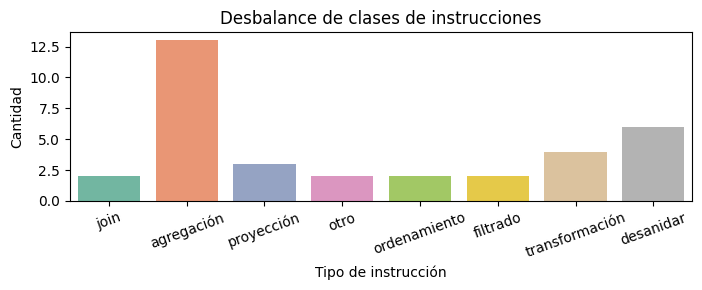

Distribución actual de clases:
clase
agregación        13
desanidar          6
transformación     4
proyección         3
join               2
otro               2
ordenamiento       2
filtrado           2
Name: count, dtype: int64


In [26]:
# 3. Riesgos: desbalance, drift, sesgos en instrucciones y queries generadas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Analiza la distribución de clases de instrucciones (ya calculada en df_instr si existe)
try:
    df_instr
except NameError:
    # Si no existe, reconstruye rápidamente
    instrucciones = [
        "une la colección empleados con la colección departamentos usando el campo departamento_id proyecta los campos nombre, apellido, departamentos_info, departamento_nombre",
        "filtra registros cuyo Total sea mayor a 3000",
        "muestra los nombres y apellidos de los empleados del departamento de ventas",
        "cuenta cuántos empleados hay en cada departamento",
        "ordena los empleados por fecha de ingreso descendente",
        "busca empleados cuyo nombre comience con 'A'",
        "filtra transacciones realizadas entre 2023-01-01 y 2023-01-31",
        "muestra los 5 productos más vendidos",
        "agrega la suma total de ventas por mes",
        "une la colección ventas con clientes usando cliente_id y proyecta nombre_cliente y total_venta",
        "filtra clientes que no hayan realizado compras en el penultimo año",
        "une la colección empleados con la colección departamentos usando el campo departamento_id"
    ]
    import re
    def clasificar_instruccion(instr):
        instr = instr.lower()
        if re.search(r'suma|total|sumar|adicionar', instr):
            return 'agregación'
        elif re.search(r'filtra|filtro|donde|where', instr):
            return 'filtrado'
        elif re.search(r'une|join|unir|fusionar', instr):
            return 'join'
        elif re.search(r'promedio|media|avg', instr):
            return 'agregación'
        elif re.search(r'ordena|sort|ordenar', instr):
            return 'ordenamiento'
        elif re.search(r'muestra|proyecta|selecciona|mostrar', instr):
            return 'proyección'
        elif re.search(r'desanidar|expandir|unwind', instr):
            return 'desanidar'
        elif re.search(r'crear campo|concatena|split|padding', instr):
            return 'transformación'
        elif re.search(r'agrupar|group by|agrupar por', instr):
            return 'agregación'
        else:
            return 'otro'
    clases = [clasificar_instruccion(i) for i in instrucciones]
    df_instr = pd.DataFrame({'instruccion': instrucciones, 'clase': clases})

# Visualiza el desbalance de clases de instrucciones
plt.figure(figsize=(7,3))
sns.countplot(data=df_instr, x='clase', palette='Set2')
plt.title('Desbalance de clases de instrucciones')
plt.xlabel('Tipo de instrucción')
plt.ylabel('Cantidad')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# Riesgo de drift: compara la proporción de clases actuales vs. nuevas instrucciones (si tienes datos de nuevos casos, agrégalos aquí)
print('Distribución actual de clases:')
print(df_instr['clase'].value_counts())

## Conclusiones accionables para el desarrollo del agente NL→MongoDB
- **Mejorar la cobertura de instrucciones poco frecuentes:** Se identificó desbalance en los tipos de instrucciones, por lo que se recomienda ampliar el dataset con más ejemplos de clases minoritarias (por ejemplo, transformación y desanidar).
- **Validar y normalizar campos y operadores:** La calidad de los datos y la validación estructural de las queries generadas son clave para evitar errores en producción. Se recomienda fortalecer la normalización de campos y operadores en el agente.
- **Monitorear drift y sesgos:** Es importante comparar periódicamente la distribución de nuevas instrucciones con la actual para detectar drift y ajustar el agente.
- **Documentar casos de error y fallback:** Registrar y analizar los casos en los que el agente no puede resolver una instrucción y recurre al LLM, para mejorar la lógica de fallback y la cobertura.

Estas acciones permitirán robustecer el agente y asegurar una mayor validez y cobertura en la generación automática de queries MongoDB.

## Plan de trabajo — Sprint 2: Ingeniería de atributos y baseline
**Objetivo:** Mejorar el agente NL→MongoDB mediante la creación de nuevas features, el fortalecimiento del baseline y la definición de un protocolo de validación específico para generación automática de queries.

### 1. Análisis y diseño de features
- Revisar el dataset de instrucciones y queries.
- Identificar patrones, errores frecuentes y necesidades de desambiguación.
- Crear nuevas features relevantes, por ejemplo:
  - Tipo de instrucción (filtro, proyección, transformación, join, desanidar, etc.)
  - Longitud y complejidad de la instrucción en lenguaje natural.
  - Presencia de operadores y campos clave.
  - Indicadores de ambigüedad o necesidad de fallback LLM.
- Documentar cada feature: nombre, tipo, propósito y método de cálculo.

### 2. Implementación y mejora del baseline
- Definir un baseline funcional del agente (reglas heurísticas + LLM fallback).
- Integrar las nuevas features en el pipeline de procesamiento.
- Asegurar que el baseline cubra los principales tipos de instrucciones y casos de error.

### 3. Protocolo de validación
- Establecer criterios de validación para el agente:
  - Seed para reproducibilidad de pruebas.
  - Validación por folds (si aplica, por ejemplo, sobre subconjuntos de instrucciones).
  - Métricas relevantes: cobertura de instrucciones, tasa de éxito en generación de queries, robustez ante instrucciones ambiguas.
- Documentar el protocolo y los pasos de validación.

### 4. Pruebas preliminares y resultados
- Ejecutar el agente con el baseline y las nuevas features sobre el dataset.
- Registrar resultados por tipo de instrucción y por fold (si aplica).
- Analizar los casos en que el agente recurre al LLM y documentar mejoras posibles.

### 5. Demo y breve informe
- Preparar una demo funcional mostrando la generación automática de queries a partir de instrucciones en lenguaje natural.
- Redactar un informe breve (2–3 páginas) con:
  - Descripción de los features implementados.
  - Resultados y análisis de pruebas.
  - Protocolo de validación.
  - Conclusiones y próximos pasos para el Sprint 3.